# ASTR596, FDS: Homework set 2 - Maximum Likelihood


## Problem 1

###  Fitting a Line using a Maximum Likelihood Estimator

Last week, you implcitly fitted straight lines with methods of moments estimators (i.e. sample mean and variance) and L-estimators (median and IQR). Generally though, we want some kind of uncertainty estimate for our models, and therefore M-estimators and maximum likelihood estimators in particular are useful.

Assume the scatter in our measurements (the residuals) is generated by a gaussian process. I.e.:

>$ y_i = a x_i + b + r_i $

where $r_i$ is drawn from $N(0, \sigma)$. Here, $\sigma$ is the error the measurement induces.

To use an M-estimator/MLE, you have to specify the likelihood function. First, the probability $p(y_i|x_i, M(a, b), \sigma)$ that a particular point $y_i$ would be measured is just the normal distribution:

>$ p(y_i|x_i, M(a, b), \sigma) = N(y_i - M(x)|\sigma) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left( - \frac{(y_i - M(x_i))^2}{2 \sigma^2} \right) $.

Given what we discussed in class, we can write down the $\ln L$

>$ \ln L(a, b) = constant - \frac{1}{2 \sigma^2} \sum_{i=1}^N (y_i - M(x_i))^2 $

This is the expression that we now minimize with respect to $a$ and $b$ to find ML estimators for those parameters. 


And as we discussed in class, this is equivalent to minimizing the sum of the squares or a _least-squares method_.

## MLE with outliers

Let's apply the MLE to data with uncertainties where these uncertainties include outliers. 
I've defined a dataset below:

Your mission is to:

- write a function that computes the squared loss, and incorporates the uncertainties on the measurements, $dy$
- Fit a line to the full sample by evaluating this likelihood on a grid of a, b
- Use sigma-clipping or an L-estimator for outlier rejection and fit a line to the data with outliers rejected
- Make a QQ plot of the residuals
- Define a new likelihood function that implements the Huber loss, also incorporating the measurement uncertainties $dy$
- Fit a new line to all of the data (no outlier rejection) with the new Huber likelihod, except now use scipy.optimize.fmin instead of a grid search.
- You know the drill by now - QQ plot of the residuals

Recommended reading: David Hogg, Jo Bovy, and Dustin Lang: "Data analysis recipes: Fitting a model to data", 2010: https://arxiv.org/abs/1008.4686

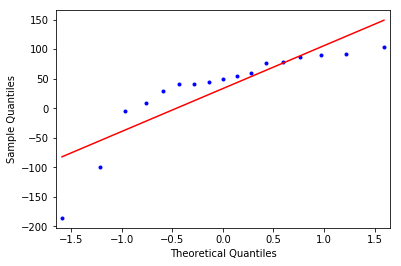

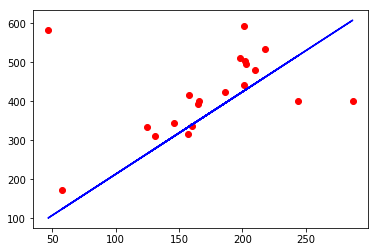

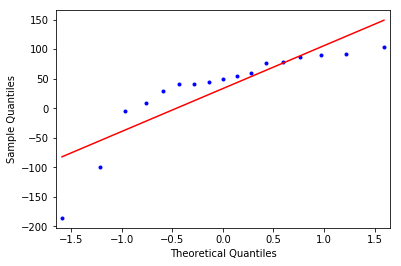

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import scipy.optimize
from astroML.datasets import fetch_hogg2010test
from astropy.stats import sigma_clip
import statsmodels.api as sm

#------------------------------------------------------------
# Get data: this includes outliers
data = fetch_hogg2010test()
x = data['x']
y = data['y']
dy = data['sigma_y']

# YOUR CODE GOES HERE
#write a function that computes the squared loss, and incorporates the uncertainties on the measurements, dy

def squared_loss(x,y,dy,a, b):
    sum_squared_loss = (y - (a*x+b+dy))**2
    return(sum(sum_squared_loss))

#Fit a line to the full sample by evaluating this likelihood on a grid of a, b
amin, amax = 0, 20
a_grid = np.arange(amin, amax, .01)
bmin, bmax = 0, 20
b_grid = np.arange(bmin, bmax, .01)

ssr = np.array([squared_loss(x,y,dy,a, b) for a,b in zip(a_grid,b_grid)])
min_step = ssr.argmin()
a = b = 0.01*min_step

#plot with new line
plt.plot(x,y,"ro")
plt.plot(x, a*x+b, "b-")

#Use sigma-clipping or an L-estimator for outlier rejection and fit a line to the data with outliers rejected
clipped_samp = sigma_clip(y, sigma=2)
clip_y = y[clipped_samp.mask == False]
clip_x = x[clipped_samp.mask == False]
clip_dy = dy[clipped_samp.mask == False]

ssr = np.array([squared_loss(clip_x, clip_y, clip_dy, a, b) for a,b in zip(a_grid,b_grid)])
min_step = ssr.argmin()
a = b = 0.01*min_step

#Make a QQ plot of the residuals
sm.qqplot(clip_y - (a*clip_x+b), line='r', marker='.')

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 51
         Function evaluations: 100


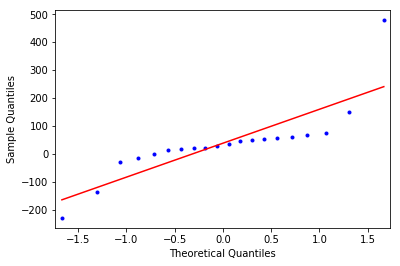

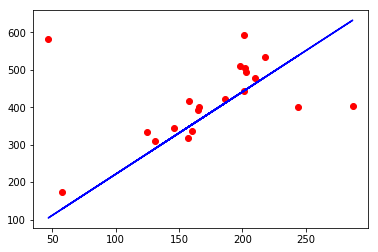

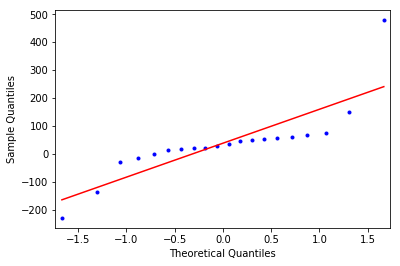

In [2]:
#Define a new likelihood function that implements the Huber loss, also incorporating the measurement uncertainties dy
#how to define tuning param? - delta = .1?
def huber_loss(params):
    a,b=params
    loss = 0
    for xn, yn, dyn in zip(x,y,dy):
        if abs(yn - (a*xn+b+dyn))<=.1:
            return((yn - (a*xn+b+dyn))**2)
    else:
        return(.1*(abs((yn - (a*xn+b+dyn)) - .5*.1)))

#Fit a new line to all of the data (no outlier rejection) with the new Huber likelihod, except now use scipy.optimize.fmin instead of a grid search.
guess_huber=[1,1]
minimum2= scipy.optimize.fmin(huber_loss, guess_huber)
minimum2
plt.plot(x,y,"ro")
a = minimum2[0]
b = minimum2[1]
plt.plot(x, a*x+b, "b-")

#QQ plot of the residuals
sm.qqplot(y - (a*x+b), line='r', marker='.')

## Example 2: Optimal Photometry

We now turn to examples of applications of ML in astronomy. 

We'll look at two cases: simple photometry and simultaneous fitting of galaxy size and total flux.

Last week, I had you download a bunch of SDSS data files and plot `MAG_PSF` from them?
But what is this quantitiy and where the heck did it come from?

Have a look at one of the example images we saw as an example of astronomical data

In [41]:
### RUN THIS CELL 
import ds9
! ds9 -scale zscale ../../data/01/wdd7.071117_0328.073_6.sw.fits

'ds9' is not recognized as an internal or external command,
operable program or batch file.


## A star and a point spread function

The stars in those images are not point sources, despite being trillions of kilometers from us. This is because as the light from the stars meet travel to meet their fate on our CCD detectors here on Earth, it gets spread out from a perfect point.

The **Point Spread Function** (the "PSF") is comprised of various contributions: from minute misalignments in the optics, to jitter in the tracking, to diffraction from the spider, to diffusion of the electrons as they travel through the silicon in the CCD ("charge diffusion"), to the homogenization of the PSF due to the refraction and diffraction in the atmosphere.  

The dominant effect is the one ***from the atmosphere***.

![PSF Formation](figures/psf-formation.jpg)

PSF is a function that describes how a point source, such as a star, would appear on earth and include the effects of the various factors that distort the source

In practice, we don't construct the PSF from *ab initio* considerations because it's impractical to track each of these effects separately.

Instead, we measure it by looking at the observed shape of bright, isolated, point sources (i.e., stars). Those observations are noisy, so we fit analytical profiles to estimate the true PSF.

For simplicity, we will use just a single bivariate Gaussian here.

This is our model.



As before, we'll generate some data - but not for 1000s of sources. Just one. It'll be stored in a variable named `image`
You can see the true parameters of the image 

Want to estimate true PSF-do this by looking at distorted image. 

PSF if single bivariate Gaussian

-2 random variables - 2 distributions must estimate
-3-D bell curve

In [2]:
# DO NOT ALTER THIS CODE:
import numpy as np
import math
import matplotlib.pyplot as plt
from astroML.plotting.mcmc import convert_to_stdev
np.random.seed(seed=42)

def plotCutout(img, title = None, clabel='$counts$', xlabel='x (pixels)', ylabel='y (pixels)', loc=None, fig=None):
    """Make a nice looking plot of a small image"""
    if loc is None:
        fig, ax = plt.subplots(figsize=(8,8))
        fig.subplots_adjust(right=0.8, bottom=0.34)
    else:
        ax = fig.add_subplot(loc)

    # coordinate of the edge (assuming a square image)
    xe = img.shape[0] / 2.

    if title is None:
        title = "min = %.0f, max=%.0f" % (img.min(), img.max())
    
    ax.set_title(title, fontsize=14)
    plt.imshow(img, origin='lower', interpolation='nearest',
           extent=(-xe, xe, -xe, xe),
           cmap=plt.cm.binary, aspect=1)
    plt.clim(-20, 100)
    plt.colorbar().set_label(clabel)

    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)


# These will be the parameters of our image:

Atrue = 10000.0    # the source count normalization
xdim = 15         # width of the image
ydim = 15         # height of the image
muXtrue = 0.0     # source x centroid 
muYtrue = 0.0     # source y centroid 
sigmaPSF = 1.5    # in pixels, corresponds to seeing = 1.5*0.2*2.355 = 0.7 arcsec for LSST (0.2" pix)
skyBg = 25        # sky background


def makePSF(shape, x0, y0, sigmaPSF):
    # Add a (Gaussian) PSF of width sigmaPSF, centered on (x0, y0)
    xx = np.arange(shape[0]) - shape[0]/2.+0.5
    yy = np.arange(shape[1]) - shape[1]/2.+0.5
    
    r = np.sqrt((xx[:, None]-x0)**2 + (yy[None, :]-y0)**2)
    psf = np.exp(-r**2./2./(sigmaPSF**2.)) / (np.sqrt(2.*math.pi)*sigmaPSF)
    return psf

fig = plt.figure(figsize=(12,18))

# uniform flux
image = np.zeros((xdim, ydim))
image[7,7] = Atrue
plotCutout(image, loc=321, fig=fig, title="Truth")

# random Poisson process
image = np.zeros((xdim, ydim))
image[7,7] = np.random.poisson(Atrue)
plotCutout(image, loc=322, fig=fig, title="Perfect detector, no atmosphere")

# PSF 
image = np.zeros((xdim, ydim))
image = Atrue * makePSF(image.shape, 0, 0, sigmaPSF)
plotCutout(image, loc=323, fig=fig, title="Now with atmosphere")



# PSF with background
image += skyBg
plotCutout(image, loc=324, fig=fig, title="Now with atmosphere and background")

# PSF with background and noise
image = np.random.poisson(image)
plotCutout(image, loc=325, fig=fig, title="W/ Atmosphere,background and noise")

simulatedImage = image

## Photometry (measuring the flux)

We now have an image that we observe, and some ***understanding of the processes that created it***.
We have encoded that understanding into a model.
This means you can now use maximum likelihood to estimate the parameters of the underlying source - like the total area under the profile - a measurement of how much light we received from the source, or it's `FLUX`

The `MAG_PSF` you plotted from the SDSS HLC files last week is directly related to the flux by $-2.5*log_{10}(\text{Flux}) + \text{Constant}$

A = Flux
-so, need to find PSF so that can find A? Since A is objective...do I just assume that I know the PSF?

Pixel = Flux*(flux at normalized point) + noise~N(0, sqrt(Pixel+Background))

For PSF, is this something that we don't know because it's PSF(x0, y0) and uses A? Also, why is it PSF(x0, y0) and not PSF(x-x0, y-y0) as in the formula for I?

What is difference between I= image pixels, psf=function

## PSF Photometry: A Maximum Likelihood estimation of the flux

So our **model** for the image is that it consists of a Gaussian with a flux normalization fo $A$ , plus the background (which we've removed), plus the Gaussian noise (caused by photon quantization).

So, <u>**once the background is removed**</u>, for ***each pixel*** I can write:

>$ I(x,y) = A * PSF(x - x_0, y - y_0) + r_i $

where $A$ is the flux of the star (i.e. the thing we want), and $r_i$ is drawn from a Gaussian with

>$N(0, \sigma_{x,y} = \sqrt{I_{x,y} + B})$

and $B$ is the sky background. It's critical not to forget the background when computing the sigma -- for faint sources, this is where most of the measurement uncertainty comes from!

### For a single pixel 

### $$
\begin{align}
p(I(x_i, y_i)|A, PSF(x_i-x_0, y_i-y_0), \sigma) &= N(I(x_i, y_i) - A*PSF(x_0, y_0)|\sigma) \\
& = \frac{1}{\sqrt{2 \pi \sigma^2}} A\exp \left( - \frac{(I(x_i, y_i) - A*PSF(x_0, y_0))^2}{2 \sigma^2} \right) 
\end{align}
$$

### For a whole image then $p1 \times p2 \times p3$....

### $$ 
\begin{align}
P &= \Gamma p(I(x, y)|A, PSF(x_i-x_0, y_i-y_0), \sigma) \\
& = N(I(x_i, y_i) - A*PSF(x_0, y_0)|\sigma) \\
& = \frac{1}{\sqrt{2 \pi \sigma^2}} A\exp \left( - \frac{(I(x_i, y_i) - A*PSF(x_0, y_0))^2}{2 \sigma^2} \right) 
\end{align}
$$

Note this is practically identical to our case with fitting a line, except that instead of having one index $i$, we have two indices for the data points, $(x, y)$. And ***each pixel*** is an independent data point that constrains our model.

So we can readily write out the log-likelihood as:

### $$\ln{L} = \text{constant} - \sum_{i=1}^N \frac{\left(I(x_i,y_i) - A\  \mathrm{PSF}(x_0,y_0)\right)^2}{2 \sigma^2}$$

As we've seen , maximizing the likelihood of a product of normal distribution reduces to minimizing the $\chi^2$, which is what you'll do next.

## Q2.1 Assume the noise is constant, and minimize the log-likelihood analytically. 
(i.e. some calculus required)

You may wish to define these quantities:

>$\phi_{x,y} = \frac{1}{\sigma^2} \sum_{x,y} I_{x,y}\cdot PSF_{x,y,\sigma_{PSF}}$
                             
>$\psi_{x,y} = \frac{1}{\sigma^2} \sum_{x,y} PSF_{x,y,\sigma_{PSF}}^2$


Looking at the form of $\phi_{x,y}$ and considering it for each pixel **what does it represent?**

## YOUR ANSWER HERE

$$\ln{L} = \text{constant} - \frac{1}{\sigma^2}\sum_{i=1}^N {I(x_i,y_i)^2} + 2 \cdot \frac{1}{\sigma^2} \sum_{x,y} I_{x,y}\cdot A \cdot PSF_{x,y,\sigma_{PSF}} - \frac{1}{\sigma^2}\sum_{i=1}^N {A^2} \cdot PSF_{x,y,\sigma_{PSF}}^2  $$
 
$$derivative =  2 \cdot \phi_{x,y} - 2 \cdot A \cdot \psi_{x,y}$$
$$A = \frac{\phi_{x,y}}\psi_{x,y}  =  \frac{PSF_{x,y}} I_{x,y}$$

## Q2.2 Estimating the true flux

To estimate the true flux, we need to maximize the likelihood. That is equivalent to minimizing the $\chi^2$. 

* estimate the background in the image
* estimate the noise in our measurements (remember it's a Poisson process!)
* as with the straight line estimate the true flux grid of A
* Destermine the chi-sq/DoF at each location on the A grid and plot it
* Compare the numerical estimate with your analytical estimate that you made with your answer to Q2.1

In [73]:
np.size(ssr)

1000

163151.4211391825

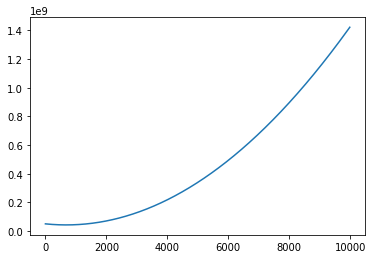

In [99]:
#want to estimate true PSF - need A to do so
# YOUR CODE GOES HERE - regarding data generated
#background
skybg = 25
sigmaPSF = 1.5
xdim = 15         # width of the image
ydim = 15         # height of the image
#noise - poisson - var = lambda
#thus,sigma of image = sqrt(I)
sigma = np.sqrt(simulatedImage)
#true flux grid - use grid approach to determine A - minimize chi sq = (I-A*PSF)^2
I = simulatedImage
x0 = 0
y0 = 0
Amin, Amax = 0, 10000
A_grid = np.arange(Amin, Amax, 10)
x = xdim
y = ydim

#im not sure what the equation is here... I is just simulated image data? Also, do i have to resimulate data without bkg?
def sum_squared_loss(x0,y0, I, xdim, ydim, A, skybg):
    sigma = np.sqrt(I+skybg)
    #I-(A*PSF + r)
    ssr = (simulatedImage - (A*makePSF(simulatedImage.shape, x0, y0, sigmaPSF)+sigma))**2
    return(sum(sum(ssr)))

ssr_sum = np.array([sum_squared_loss(x0,y0, I, xdim, ydim, A, skybg) for A in A_grid])
min_A = (ssr_sum.argmin())*10
min_A

#chi-sq/dof and plot
#chi_sq = ssr/(I)
def chi_squared(x0,y0, I, xdim, ydim, A, skybg):
    sigma = np.sqrt(I+skybg)
    #I-(A*PSF + r)
    ssr = ((simulatedImage - (A*makePSF(simulatedImage.shape, x0, y0, sigmaPSF)+sigma))**2)/simulatedImage
    return(sum(sum(ssr)))
dof = np.size(simulatedImage)
plt.plot(A_grid, ssr_sum)
#compare numerical and analytical estimate
#numerical

numeric = sum(sum(simulatedImage/makePSF(simulatedImage.shape, x0, y0, sigmaPSF)))
numeric

## Models with more parameters

The iterative example above is a bit contrived as we can, and did, solve the MLE analytically 

It has the benefit of being general, however. We can apply the same technique to models with more parameters (within the limits of computing power available to us!). The other parameters could be the position of the object ($x$, $y$), or some measure of the shape of the object.

As the number of parameters increases, the likelihood curve from the previous slide becomes the ***likelihood (hyper)surface***. The more dimensions there are, the more difficult (computationally expensive) it becomes to find its maximum using brute force solutions; even for 2D cases, we're likely to resort to ***minimization algorithms*** (e.g., Levenberg–Marquardt or others).

## Q3: Measuring the size and brightness of a spherical, gaussian, galaxy

In Homework 1, you had `MAG_PSF` not just for stars, but also for galaxies. 

Even in the ideal (space) case, the Galaxy will not be a point source. We'll imagine we're dealing with a "Gaussian spherical galaxy" -- i.e., one whose intensity  falls of as a 2D gaussian would. As with the star, we'll asume the position of the galaxy is known.

Our model has two parameters: the measure of the extendedness of the galaxy -- $\sigma$ -- and its total flux, $C$:

>$ I(x, y) = \frac{C}{2 \pi \sigma^2} \exp \left( -\frac{(x-x_0)^2 + (y-y_0)^2}{2\sigma^2} \right) $

We will now have to explore the likelihood surface in $(C, \sigma)$ space, and find the point of its maximum.

Note #2: When generating the simulated image, $I(x, y)$ needs to be ***convolved*** with the PSF. Fortunately (actually, because I'm lazy) we've chosen the galaxy profile to be gaussian, and the convolution of two gaussians with variances $\sigma_1^2$ and $\sigma_2^2$ is also a gaussian with the variance $\sigma_1^2 + \sigma_2^2$ (i.e., it's wider). 

Our function `gauss2D` utilizes this fact to generate the convolved image of the galaxy.

* we will generate two cases with `gauss2D` below:
* using this image as your data evaluate the log-likelihood
    * in Q2, we only did this for the flux $A$
    * now you have two parameters $C$ and it's shape $\sigma$
    * evaluate the likelihood on this grid 
    
    `C = np.linspace(500, 1500, 101)`
    
    `Sigma = np.linspace(0, 2.5, 101)`
    
* plot the noiseless image and the PSF image, returned by `simulate`, `image` itself, and the difference between image and PSF image (also returned by simulate), and your estimated log-likehood surface

-basically, once again I is probability and want to maximize its product, which is the same as minimizing the log likelihood. But this time, want to evaluate over 2 unknowns.
-given grid to do this over

In [7]:
import math

def gauss2D(muX, muY, sig, A, skyBg, sigPSF, Xpixels, Ypixels):
    """
    Generate an image of size (Xpixels, Ypixels) with
    a 2D circular Gaussian of total flux A
    with standard deviation sigma^2=sig^2 + sigPSF^2
    superimposed on a uniform background B and centered
    on (muX, muY).
    """
    r = np.sqrt((Xpixels-muX)**2 + (Ypixels-muY)**2)
    # make and set image to the background value
    image = np.empty(r.shape)
    image.fill(skyBg)

    ## now add circular gaussian profile (normalized to A)
    # source gauss convolved with single-gauss PSF  
    sigConvSquare = sig**2 + sigPSF**2
    image += A*np.exp(-r**2/2/sigConvSquare) / (2*math.pi*sigConvSquare)
    return image


def addnoise(inimage, sigNoise, sourceImage, addsourcenoise=0): 
    """Add gaussian noise to the image, and return the image and variance plane"""
    image = np.copy(inimage)
    image += np.random.normal(0, sigNoise, image.shape)
    variance = 0*image + sigNoise**2

    if (addsourcenoise):
        gain = 1.0  # as a reminder...
        sourceVariance = sourceImage/gain
        image += np.random.normal(0, np.sqrt(sourceVariance), image.shape)
        variance += sourceVariance

    return image, variance 


def simulate(muXtrue, muYtrue, sigtrue, Atrue, skyBg, sigmaPSF, sigmaNoise):
    # set seed
    np.random.seed(42)
    
    # define the (square) grid
    xpix = np.linspace(-7, 7, 15)

    ## make psf (sigtrue=0) 
    psf = gauss2D(muXtrue, muYtrue, 0, Atrue, skyBg, sigmaPSF, xpix[:, np.newaxis], xpix)

    ## make noiseless image (convolved with psf given by sigmaPSF, image size given by 1Dpixels) 
    nonoise = gauss2D(muXtrue, muYtrue, sigtrue, Atrue, skyBg, sigmaPSF, xpix[:, np.newaxis], xpix)
 
    ## now add noise
    image, variance = addnoise(nonoise, sigmaNoise, 0) 

    ## difference object - psf
    diffimage = image - psf

    return nonoise, psf, image, diffimage


# Case 1 - a sanity check - if sigtrue (i.e. the shape of the galaxy) is 0 we're back to dealing with a single star.

In [8]:
muXtrue = 0.0     # source x centroid 
muYtrue = 0.0     # source y centroid 
sigtrue = 0.0     # the intrinsic gaussian source width, sigma (in pixels) 
Atrue = 1000.0    # the source count normalization
skyBg = 25        # sky background
sigmaPSF = 1.5    # in pixels, corresponds to seeing = 1.5*0.2*2.355 = 0.7 arcsec for LSST (0.2" pix)
sigmaNoise = 5.0  # gaussian sigma for white noise (counts), e.g. due to sky 


nonoise, psf, image, diffimage = simulate(muXtrue, muYtrue, sigtrue, Atrue, skyBg, sigmaPSF, sigmaNoise)

In [7]:
# YOUR CODE TO SOLVE THE HOMEWORK GOES HERE - TRY TO MAKE A FUNCTION YOU CAN REUSE FOR CASE 2
#create function to solve log likelihood like in question 2 and do plots - solving for c and sigma on respective grids
C = np.linspace(500, 1500, 101)
Sigma = np.linspace(0, 2.5, 101)
#plot the noiseless image and the PSF image, returned by simulate, image itself, and the difference between image and PSF image 
#(also returned by simulate), and your estimated log-likehood surface

# Case 2 - if sigtrue is non-zero, we're dealing with a spherical cow galaxy

In [8]:
muXtrue = 0.0     # source x centroid 
muYtrue = 0.0     # source y centroid 
sigtrue = 1.0     # the intrinsic gaussian source width, sigma (in pixels) 
Atrue = 1000.0    # the source count normalization
skyBg = 25        # sky background
sigmaPSF = 1.5    # in pixels, corresponds to seeing = 1.5*0.2*2.355 = 0.7 arcsec for LSST (0.2" pix)
sigmaNoise = 5.0  # gaussian sigma for white noise (counts), e.g. due to sky 

nonoise, psf, image, diffimage = simulate(muXtrue, muYtrue, sigtrue, Atrue, skyBg, sigmaPSF, sigmaNoise)

# IF YOU WROTE A SENSIBLE FUNCTION FOR THE STAR CASE, YOU CAN JUST REUSE IT HERE!

Every one of the measurements in the SDSS HLC files was estimated using a more sophisticated version of this process.